In an autoregressive process, $y_t$ depends linearly on its previous values i.e. it is a regression of the variable against itself. An $\text{AR}(p)$ process, where $p$ is the order is defined as:

$$
y_t=C+\phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t
$$

The random walk $y_t = C + y_{t-1} + \epsilon_t$ is a special case ($p=1, \phi_q = 1$) of the autoregressive process, where $C$ is the drift. The order $p$ influences the # of parameters included in the model, so it is important to use the right order $p$ to build the appropriate model to the data.

To check if a process is $\text{AR}$ is as follows:
- Is it stationary?
    - No? Apply transformations.
    - Yes? Plot ACF. Is there autocorrelation?
        - No? It is a random walk.
        - Yes? Do autocorrelation coefficients become abruptly non-significant after lag $q$?
            - Yes? It is a $\text{MA}(q)$ process.
            - No? Plot PACF. Do coefficients become abruptly non-significant after lag $q$?
                - Yes? An $\text{AR}(p)$ process.
                - No? Not an $\text{AR}(p)$ process.

In [1]:
import pandas as pd

df = pd.read_csv('data/foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


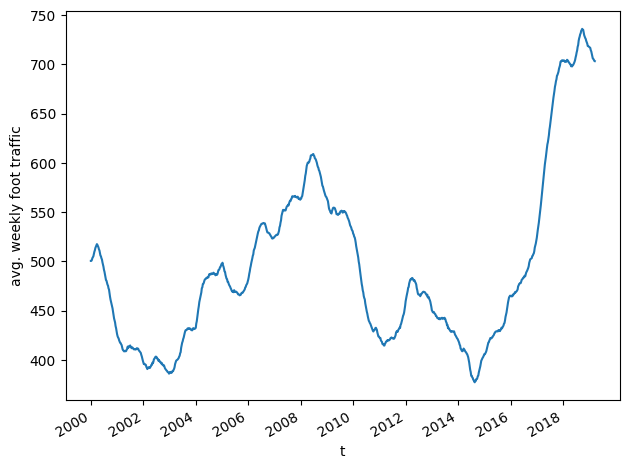

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

fig, ax = plt.subplots()
ax: Axes

ax.plot(df['foot_traffic'])
ax.set_xlabel('t')
ax.set_ylabel('avg. weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
fig.tight_layout()

In [3]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['foot_traffic'])
print(f'ADF statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF statistic: -1.176
p-value: 0.684


A ADF statistic of -1.176 and a p-value of 0.684 indicate that we cannot reject the null hypothesis and $\therefore$ the data is non-stationary.

In [4]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

ADF_result = adfuller(foot_traffic_diff)
print(f'ADF statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF statistic: -5.268
p-value: 0.000


We can reject the null hypothesis and $\therefore$ the `diff` is stationary.

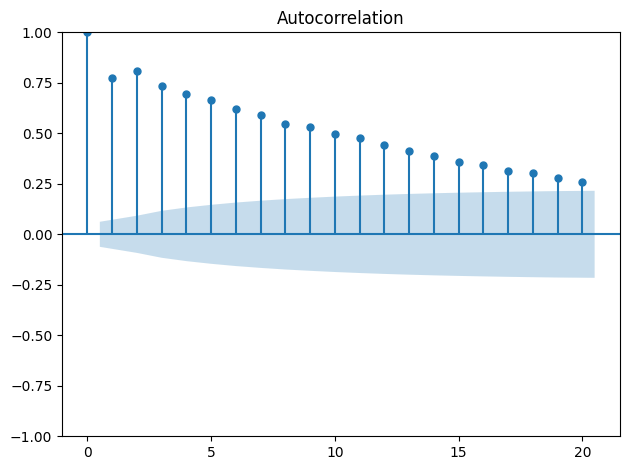

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(foot_traffic_diff, lags=20)
plt.tight_layout()

We see that the autocorrelation coefficients are decaying asymptotically as the lag increases $\therefore$ there is no lag at which the coefficients become abruptly non-significant. This means that we do not have a $\text{MA}(q)$ process and instead have an $\text{AR}(p)$ process.

We need to identify the $p$ of the $\text{AR}(p)$ process. Suppose we have this $\text{AR}(2)$ process: $y_t=0.33y_{t-1}+0.50y_{t-2}$. We wish to measure how $y_t$ relates to $y_{t-2}$ i.e. their correlation. However, recall that $y_{t-1}=0.33y_{t-2}+0.50y_{t-3}$ so $y_{t-2}$ also relates to $y_{t-1}$. Therefore, in attempting to measure the influence that $y_{t-2}$ has on $y_t$, we also include the influence of $y_{t-1}$ which depends on $y_{t-2}$ as well. To measure their true impact, we have to remove the effect of $y_t-1$. I.e. a partial autocorrelation means the correlation between lagged values in a time series when we remove the influence of correlated lagged values in between i.e. confounding variables.

Proof: Let $y_t$ be the independent variable, and $y_{t-2}$ be the dependent variable. $y_{t-1}$ is a confounding variable because it is correlated with the independent variable $y_t$ and is causally related to the dependent variable $y_{t-1}$.

In [6]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ma2 = np.array([0, 0])
ar2 = np.array([-0.33, -0.5])
ma2 = np.r_[1, ma2]
ar2 = np.r_[1, ar2]

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

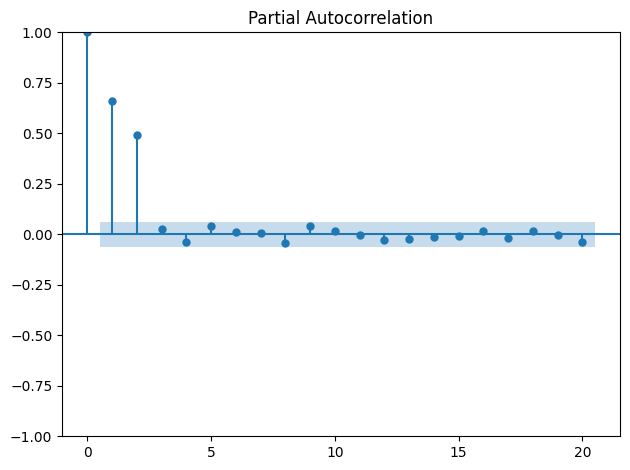

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)

plt.tight_layout()

We see in this case that there are no significant partial autocorrelation coefficients (PACs) after lag 2. This expected since we simulated an $\text{AR}(2)$ process.

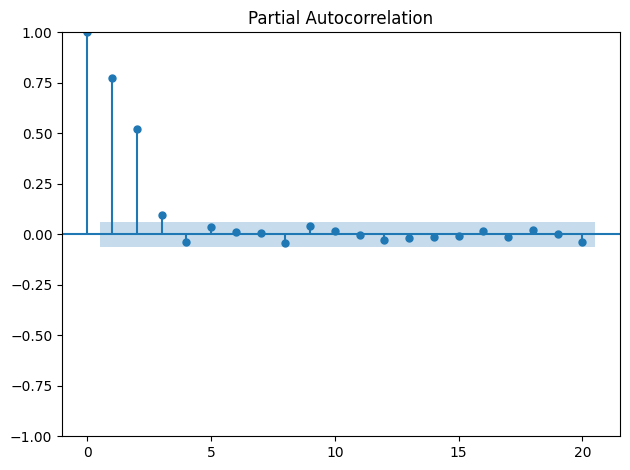

In [8]:
plot_pacf(foot_traffic_diff, lags=20)
plt.tight_layout()

We see here that foot traffic is an $\text{AR}(3)$ process.

In [9]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
n_test_samples = 52
train = df_diff[:-n_test_samples]
test = df_diff[-n_test_samples:]
print(len(train), len(test))

947 52


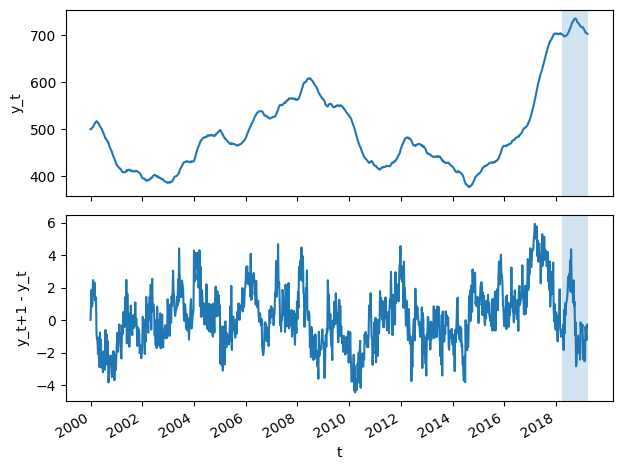

In [18]:
test_start = len(df)-n_test_samples

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1: Axes; ax2: Axes

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('t')
ax1.set_ylabel('y_t')
ax1.axvspan(test_start, len(df), alpha=.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('t')
ax2.set_ylabel('y_t+1 - y_t')
ax2.axvspan(test_start-1, len(df)-1, alpha=.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
fig.tight_layout()

In [58]:
from typing import Literal
from statsmodels.tsa.statespace.mlemodel import PredictionResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, 
                     window: int, method: Literal['mean', 'last', 'AR']):
    if method == 'mean':
        pred_mean = np.empty(horizon)
        for i in range(0, horizon, window):
            mean = np.mean(df[:train_len+i].values)
            pred_mean[i:i+window] = mean
        return pred_mean
    elif method == 'last':
        pred_last = np.empty(horizon)
        for i in range(0, horizon, window):
            last = df[:train_len+i].iloc[-1].values[0]
            pred_last[i:i+window] = last
        return pred_last
    elif method == 'AR':
        # let the prediction "window" be i..j (inclusive) 
        # so since i <- 0..horizon-1
        #          j <- window-1..horizon+window-2
        # (sanity check: let window=1
        #  then i <- 0..horizon-1 and
        #       j <- 0..horizon-1 which is identical)
        # so the max value j can have is horizon+window-2
        # thus the array to store the prediction results
        # must have size horizon+window-1;
        pred_AR = np.empty(horizon+window-1)
        for i in range(0, horizon, window):
            model = SARIMAX(df[:train_len+i], order=(3,0,0)) # (p,d,q)
            res: SARIMAXResults = model.fit(disp=False)
            # last forecast is inclusive, so -1
            predictions: PredictionResults = res.get_prediction(0, train_len+i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR[i:i+window] = oos_pred.values
        return pred_AR[:horizon]

In [60]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test.assign(pred_mean=pred_mean)
test.assign(pred_last=pred_last)
test.assign(pred_AR=pred_AR)

test.head()

,foot_traffic_diff,pred_mean,pred_last,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


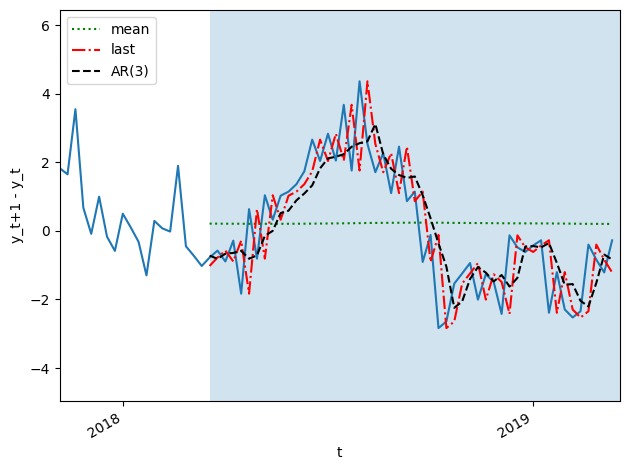

In [62]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('t')
ax.set_ylabel('y_t+1 - y_t')
ax.axvspan(test_start-1, len(df_diff), alpha=.2)
ax.set_xlim(test_start-20, len(df_diff))
plt.xticks([936, 988], [2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()

In [65]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last_value = mean_squared_error(test['foot_traffic_diff'], test['pred_last'])
mse_MA = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

for mse, label in zip((mse_mean, mse_last_value, mse_MA), ('mean', 'last', 'AR(3)')):
    print(f'{label}: {mse:.3f}')

mean: 3.108
last: 1.449
AR(3): 0.924


C:\Users\bensa\AppData\Local\Temp\ipykernel_203628\263759084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_foot_traffic'][test_start:] = (


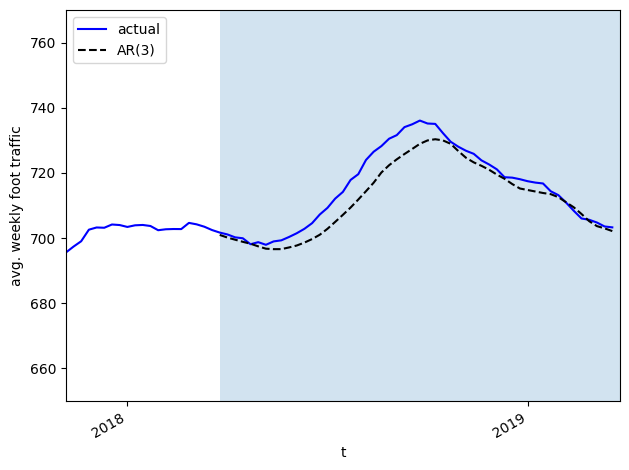

In [71]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][test_start:] = (
    df['foot_traffic'].iloc[test_start] +
    test['pred_AR'].cumsum()
)

fig, ax = plt.subplots()
ax: Axes
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('t')
ax.set_ylabel('avg. weekly foot traffic')
ax.axvspan(test_start, len(df), alpha=.2)
ax.set_xlim(test_start-20, len(df))
ax.set_ylim(650, 770)
ax.set_xticks([936, 988], [2018, 2019])
fig.autofmt_xdate()
fig.tight_layout()

In [74]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(
    df['foot_traffic'].iloc[test_start:], 
    df['pred_foot_traffic'].iloc[test_start:])

print(f'{mae_AR_undiff:.3f}')

3.478
